# NLSA: Daily Images

In [1]:
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import pandas as pd
import warnings
import scripts.helper as helper
import scripts.matrix_helper as mat_helper
from mpl_toolkits.basemap import Basemap
from scipy import signal

#Cool stuff -> Every notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data example

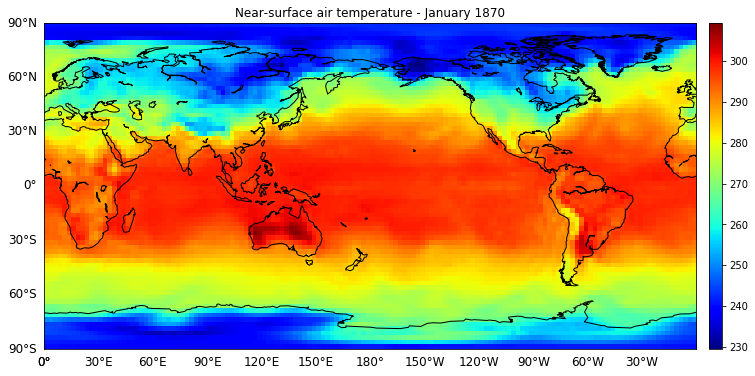

In [2]:
temp_nc = netCDF4.Dataset('../../eniko/data/tas_day_MPI-ESM-MR_rcp85_r1i1p1_g025.nc')
temp_ncdata = np.array(temp_nc.variables['tas'])

fig = plt.figure(figsize=(16,6))
long = [0, 360]
lat = [-90, 90]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
    map.drawcoastlines()
    map.drawparallels( np.arange(-90,90.01,30.0), labels = [1,0,0,0], fontsize = 12, linewidth = 0)
    map.drawmeridians( np.arange(0.,360.,30.), labels = [0,0,0,1], fontsize = 12, linewidth = 0)

    h = map.imshow(temp_ncdata[1,:], cmap = 'jet', interpolation = 'none', animated = True)
    map.colorbar(h, size = "2%")#, pad="40%", ticks = range(cmin, cmax + 1, cint))
    plt.title("Near-surface air temperature - January 1870")

## NLSA Algorithm

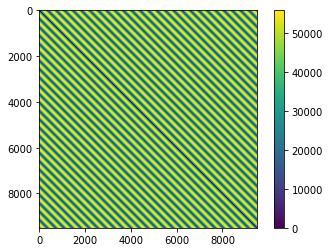

In [2]:
#Load precomputed Distance matrix -- select Daily/Monthly and 1, 5 or 10 years
D = np.load('Daily_D_Mat_5y.npy', mmap_mode='r')
plt.imshow(D)
plt.colorbar()

In [5]:
# Create the sparse matrix M
# Select K closest nearest neighbors - set the rest to 0
M = helper.select_k_closest(D, 2000)

In [6]:
# Build Kernel matrix from NLSA Algorithm - second parameter is epsilon
# Warning: this can take up to 12 minutes
K = mat_helper.build_nlsa_kernel(M, 2)

In [21]:
L = mat_helper.build_Laplace_Beltrami_operator(K)

In [23]:
# Eigendecomposition of the Laplacian - keep only the real part
w_k, v_k = eigs(L, k=100, which='SM')
w_k = np.real(w_k)
v_k = np.real(v_k)

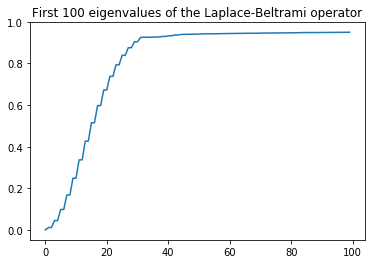

In [24]:
# Eigenvalue plot
plt.title('First 100 eigenvalues of the Laplace-Beltrami operator')
plt.plot(w_k[:100])
plt.show()

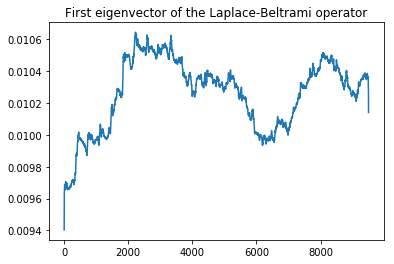

In [25]:
# Eigenvalue plot
plt.title('First eigenvector of the Laplace-Beltrami operator')
plt.plot(v_k[:, 0])
plt.show()

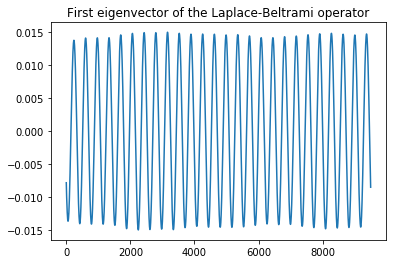

In [26]:
# Eigenvalue plot
plt.title('First eigenvector of the Laplace-Beltrami operator')
plt.plot(v_k[:, 1])
plt.show()

## Spatiotemporal Patterns Analysis

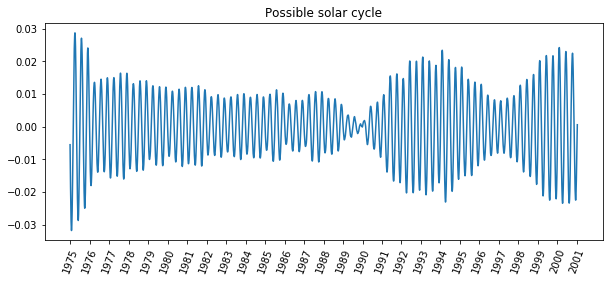

In [27]:
#Eigenvectorplot - start date = 1970 + chosen time-lag
fig = plt.figure(figsize=(10,4))
my_xticks = np.arange(1975, 2002, 1)
ax1 = fig.add_subplot(111)
ax1.set_xticks(np.arange(0, len(v_k[:, 0]), 365))
ax1.set_xticklabels(my_xticks, rotation='70')
plt.title('Possible solar cycle')
plt.plot(v_k[:, 38])
plt.show()

In [28]:
volcano_list = ['1970', '1971', '1972', 'Tiatia', 'Volcan De Fuego', 'Tolbachik', 'Mount Augustine', '1977', '1978', '1979',
               'Mount St. Helens', 'Alaid/Pagan', 'El Chichòn/Galunggung', 'Colo', '1984', 'Nevado Del Ruiz', 'Mount Augustine', 'Kliuchevskoi',
               '1988', 'Mount Redoubt', 'Kelud', 'Mount Pinatubo/Mount Hudson', 'Mount Spurr', 'Lascar', 'Rabaul Caldera', '1995', '1996',
               'Soufriere Hills', '1998', '1999', '2000', '2001']

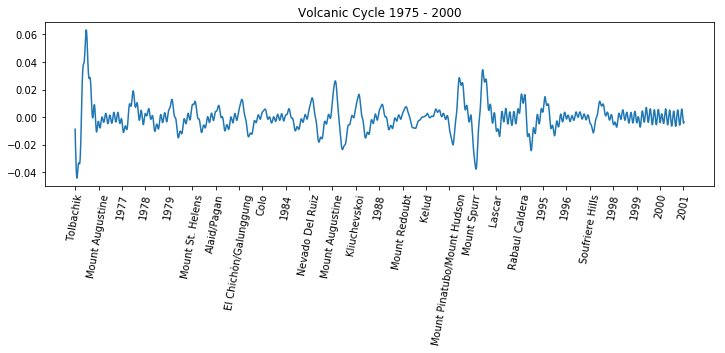

In [49]:
# Possible Volcanic activity - start date = 1970 + chosen time-lag - 1
fig = plt.figure(figsize=(12,3))
my_xticks = np.arange(1980, 2002, 1)
ax1 = fig.add_subplot(111)
ax1.set_xticks(np.arange(0, len(v_k[:, 0]), 365))
ax1.set_xticklabels(volcano_list[5:], rotation='80')
plt.title('Volcanic Cycle 1975 - 2000')
plt.plot(v_k[:, 45])
plt.show()

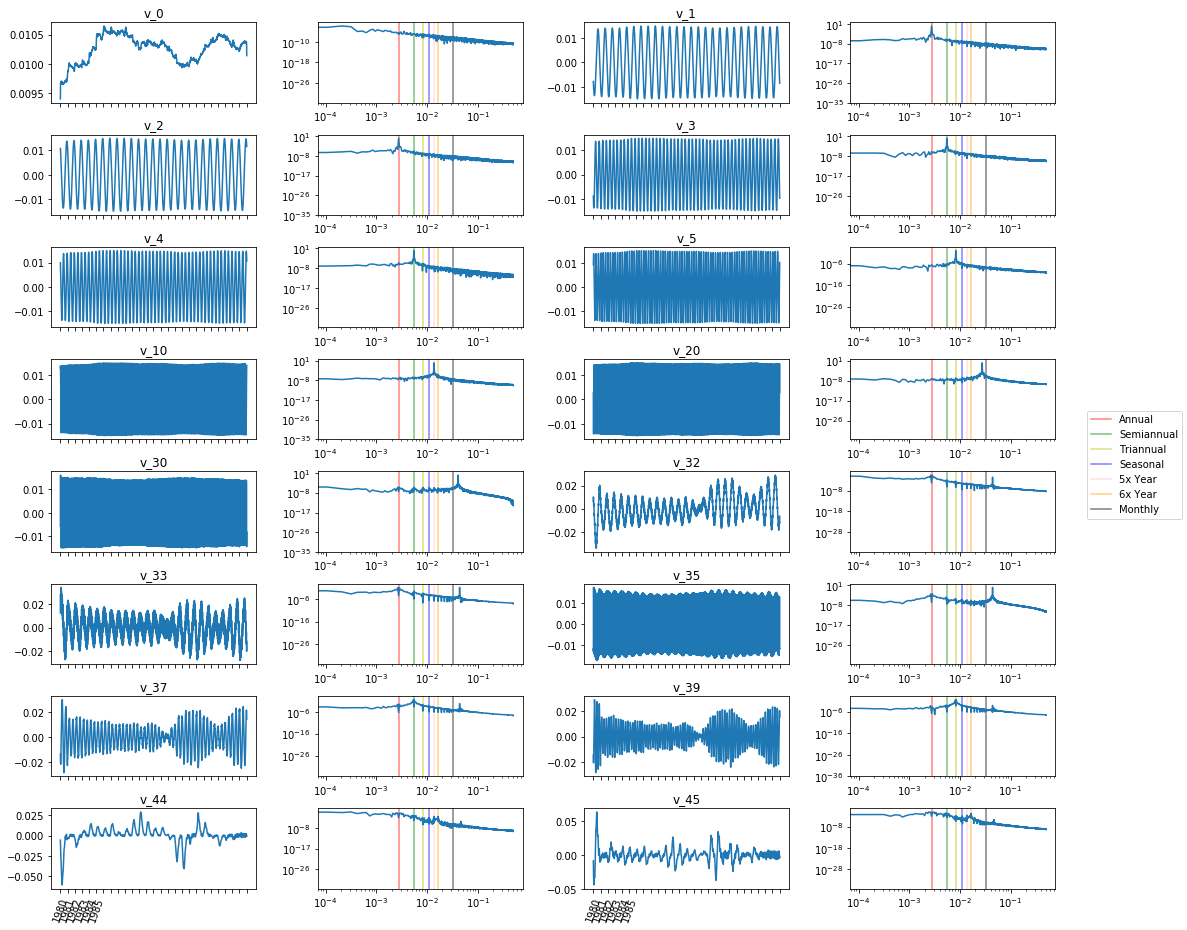

In [50]:
# Frequencies plot
list_vector = [0, 1, 2, 3, 4, 5, 10, 20, 30, 32, 33, 35, 37, 39, 44, 45]
my_xticks = np.arange(1980, 1986, 1)
fig = plt.figure(figsize=(18,18))
ind = 1
for i in list_vector:
    ax = plt.subplot(9, 4, ind)
    ax.set_xticks(np.arange(0, len(v_k[:, 0]), 365))
    
    if i == 44 or i == 45:
        ax.set_xticklabels(my_xticks, rotation='70')
    else:
        ax.set_xticklabels(['', '', '', '', '', ''], rotation='70')
        
    ind += 1
    plt.title('v_'+str(i))
    plt.plot(v_k[:, i])
    
    plt.subplot(9, 4, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]))
    #l1 = plt.axvline(x=1/(365*11), color='grey', alpha=0.5) #11y
    l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.show()

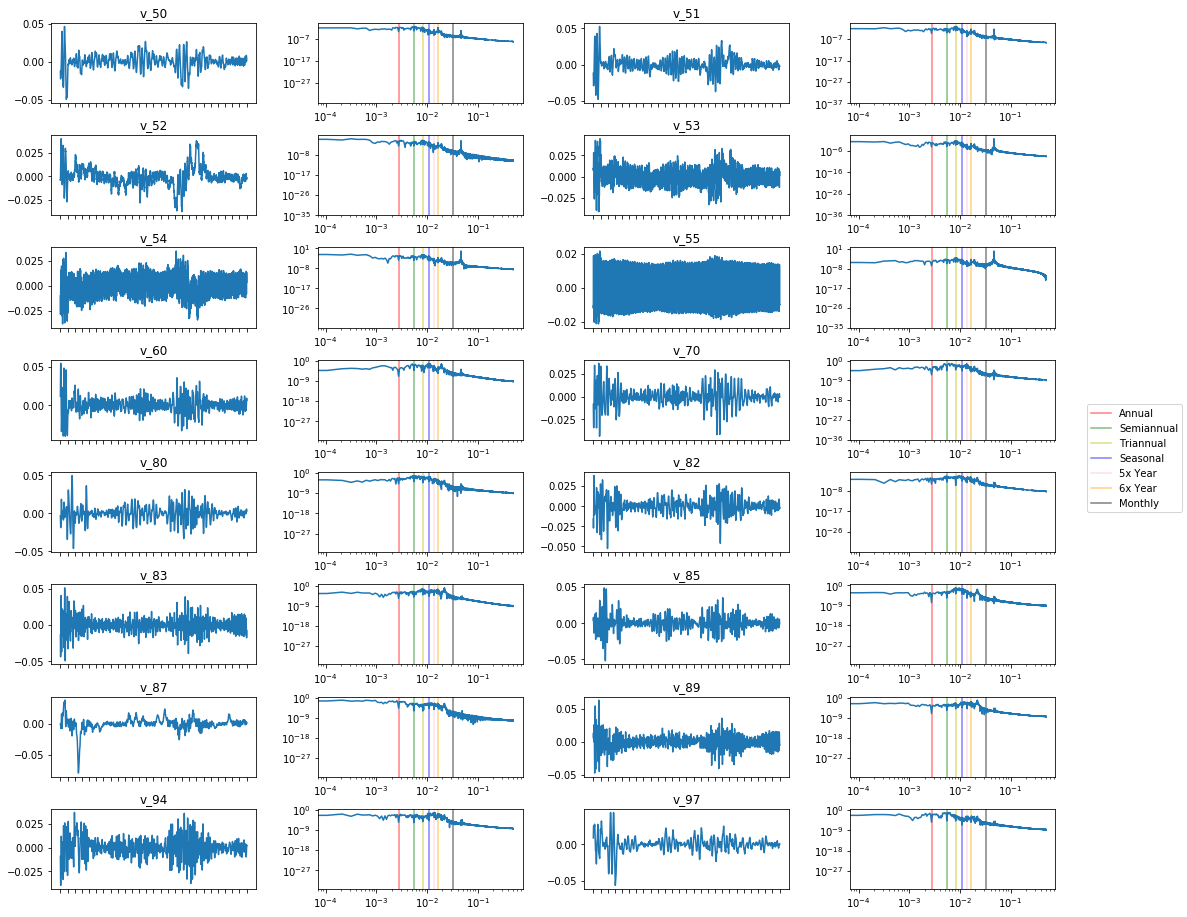

In [34]:
# Frequencies plot
list_vector = [50, 51, 52, 53, 54, 55, 60, 70, 80, 82, 83, 85, 87, 89, 94, 97]
my_xticks = np.arange(1980, 1986, 1)
fig = plt.figure(figsize=(18,18))
ind = 1
for i in list_vector:
    ax = plt.subplot(9, 4, ind)
    ax.set_xticks(np.arange(0, len(v_k[:, 0]), 365))
    
    if i == 44 or i == 47:
        ax.set_xticklabels(my_xticks, rotation='70')
    else:
        ax.set_xticklabels(['', '', '', '', '', ''], rotation='70')
        
    ind += 1
    plt.title('v_'+str(i))
    plt.plot(v_k[:, i])
    
    plt.subplot(9, 4, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]))
    #l1 = plt.axvline(x=1/(365*11), color='grey', alpha=0.5) #11y
    l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.show()

/Users/Alexis/anaconda/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


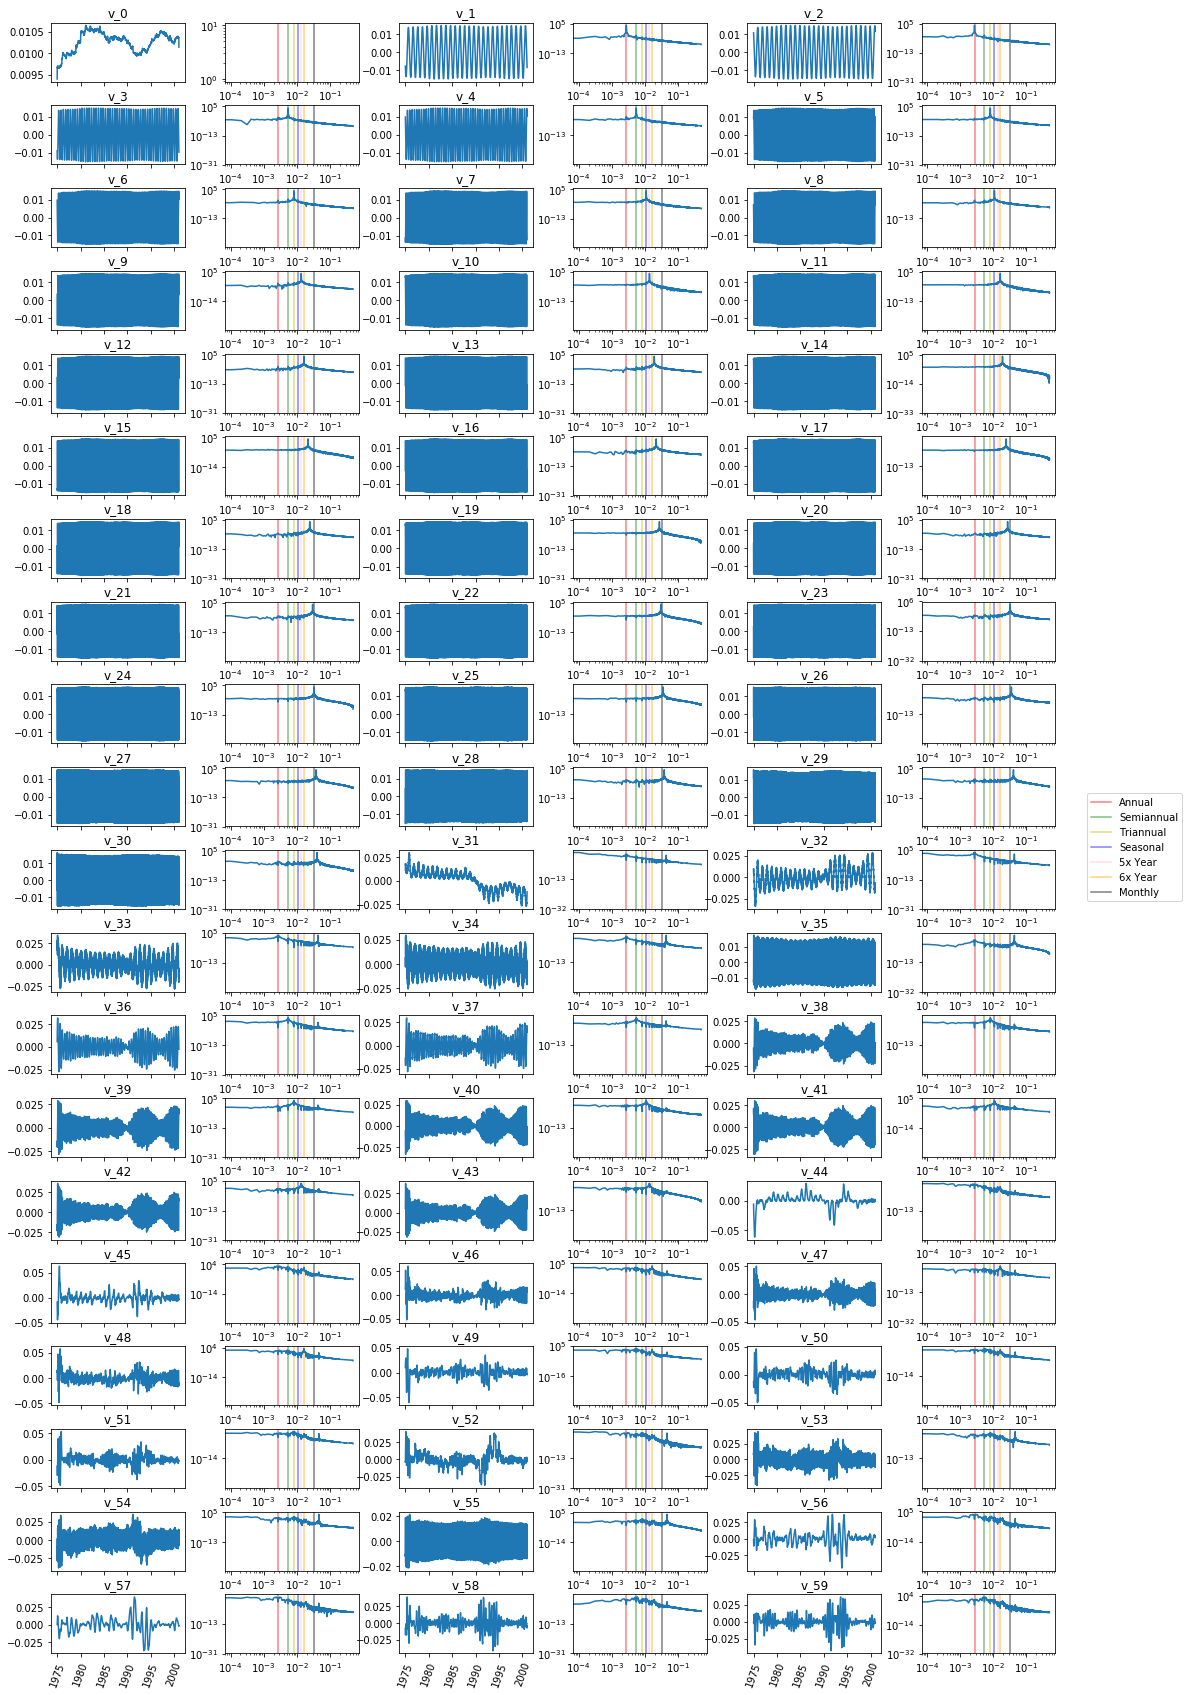

In [52]:
# Frequencies plot
#np.load("eigs.npy")
#list_vector = [0, 1, 2, 3, 4, 5, 10, 20, 30, 32, 33, 35, 37, 39, 44, 47]
list_vector = [i for i in range(0, 60)]
my_xticks = np.arange(1975, 2001, 5)
fig = plt.figure(figsize=(18, 30))
ind = 1
for i in list_vector:
    ax = plt.subplot(20, 6, ind)
    ax.set_xticks(np.arange(0, len(v_k[:, 0]), 1825))
    
    if i == 57 or i == 58 or i == 59:
        ax.set_xticklabels(my_xticks, rotation='70')
    else:
        ax.set_xticklabels(['', '', '', '', ''], rotation='70')
        
    ind += 1
    plt.title('v_'+str(i))
    plt.plot(v_k[:, i])
    
    plt.subplot(20, 6, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]/v_k[:, 0]))
    #l1 = plt.axvline(x=1/(365*11), color='grey', alpha=0.5) #11y
    l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.show()

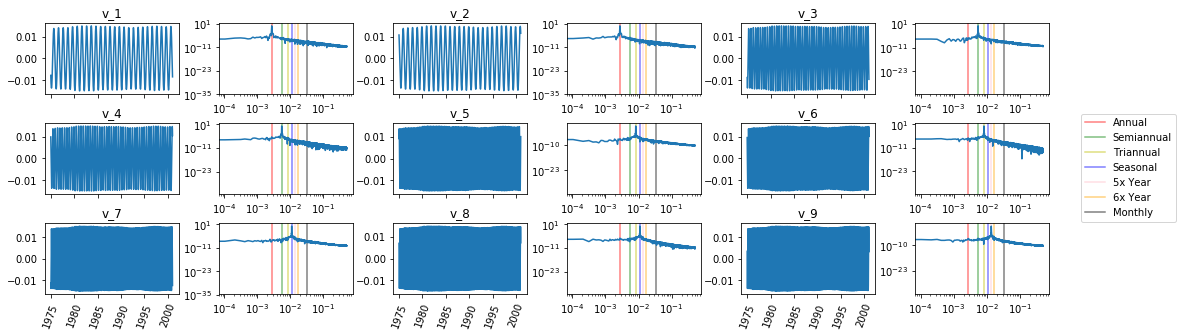

In [65]:
# Frequencies plot
list_vector = [i for i in range(1, 10)]
my_xticks = np.arange(1975, 2001, 5)
fig = plt.figure(figsize=(18,5))
ind = 1
for i in list_vector:
    ax = plt.subplot(3, 6, ind)
    ax.set_xticks(np.arange(0, len(v_k[:, 0]), 1825))
    
    if i == 7 or i == 8 or i == 9:
        ax.set_xticklabels(my_xticks, rotation='70')
    else:
        ax.set_xticklabels(['', '', '', '', ''], rotation='70')
          
    ind += 1
    plt.title('v_' + str(i))
    plt.plot(v_k[:, i])
    
    plt.subplot(3, 6, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]))
    l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.savefig('NLSA_1_9.png')

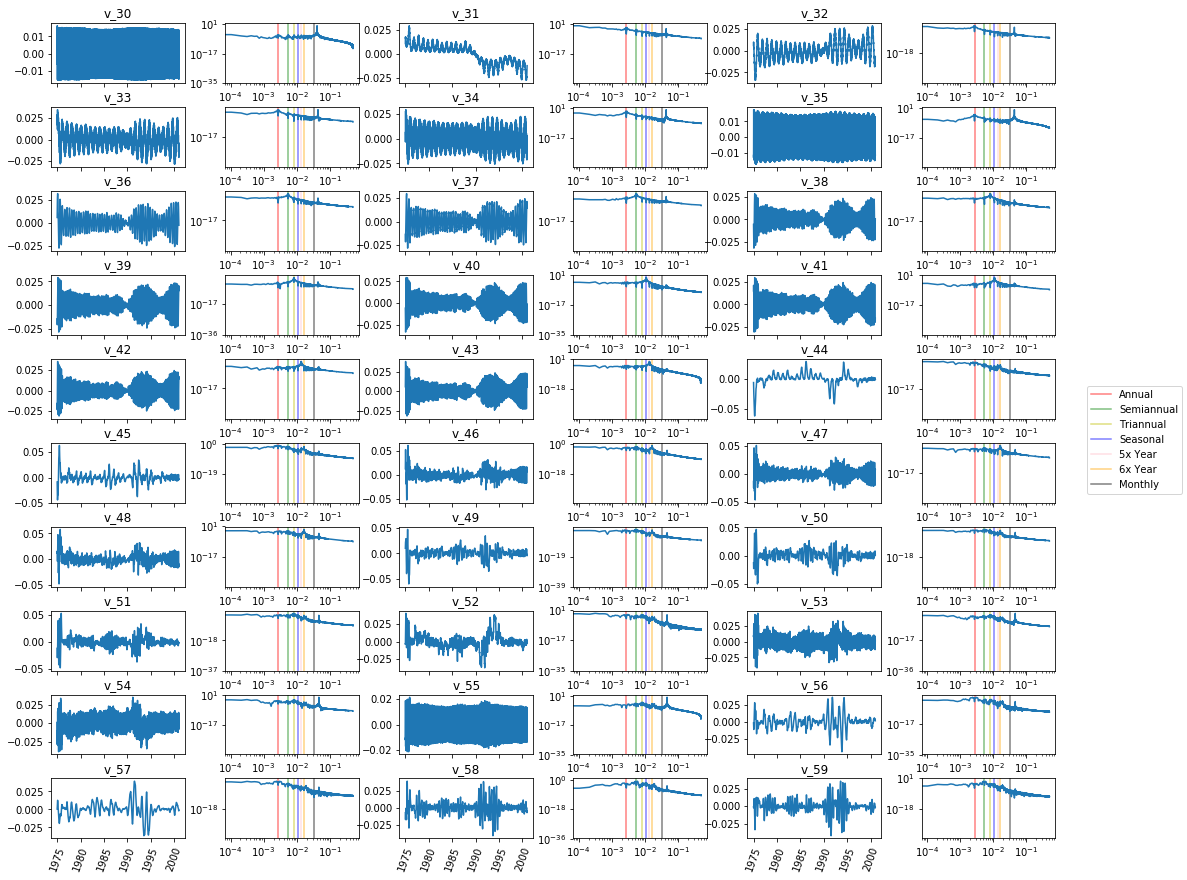

In [64]:
# Frequencies plot
list_vector = [i for i in range(30, 60)]
my_xticks = np.arange(1975, 2001, 5)
fig = plt.figure(figsize=(18,15))
ind = 1
for i in list_vector:
    ax = plt.subplot(10, 6, ind)
    ax.set_xticks(np.arange(0, len(v_k[:, 0]), 1825))
    
    if i == 57 or i == 58 or i == 59:
        ax.set_xticklabels(my_xticks, rotation='70')
    else:
        ax.set_xticklabels(['', '', '', '', ''], rotation='70')
          
    ind += 1
    plt.title('v_' + str(i))
    plt.plot(v_k[:, i])
    
    plt.subplot(10, 6, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]))
    l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.savefig('NLSA_30_60.png')

## Delay-coordinate recontruction

In [54]:
# Load original data for projection
d_data = np.load('Daily_1970_2000_data.npy')

In [55]:
chosen_vec = v_k[:, 2]
size_vec = len(chosen_vec)
resized_data = d_data[(d_data.shape[0] - size_vec):,:]
resized_data = resized_data.reshape(resized_data.shape[0], resized_data.shape[1]*resized_data.shape[2])
X = resized_data.T
s_pattern = X @ chosen_vec
spp = np.reshape(s_pattern,(-1, 72*144))
vec = np.reshape(chosen_vec, (-1, size_vec))
Y = spp.T @ vec
Z = Y.T
Z = np.reshape(Z, (size_vec, 72, 144))

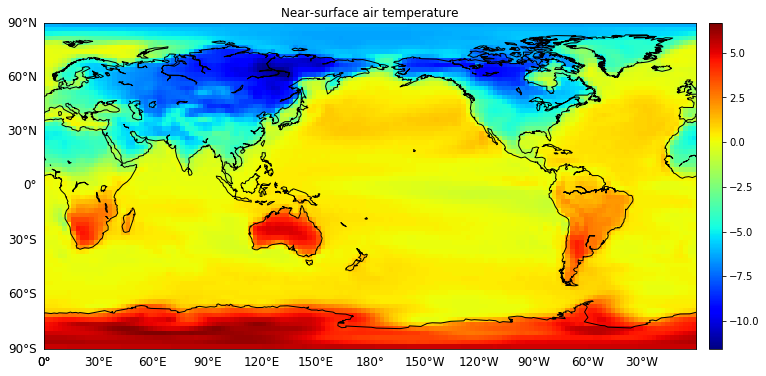

In [56]:
fig = plt.figure(figsize=(16,6))
long = [0, 360]
lat = [-90, 90]


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
    map.drawcoastlines()
    map.drawparallels( np.arange(-90,90.01,30.0), labels = [1,0,0,0], fontsize = 12, linewidth = 0)
    map.drawmeridians( np.arange(0.,360.,30.), labels = [0,0,0,1], fontsize = 12, linewidth = 0)

    h = map.imshow(Z[1, :], cmap = 'jet', interpolation = 'none', animated = True)
    #plt.clim(-m, m)
    map.colorbar(h, size = "2%")
    plt.title("Near-surface air temperature")

### Yearly reconstruction

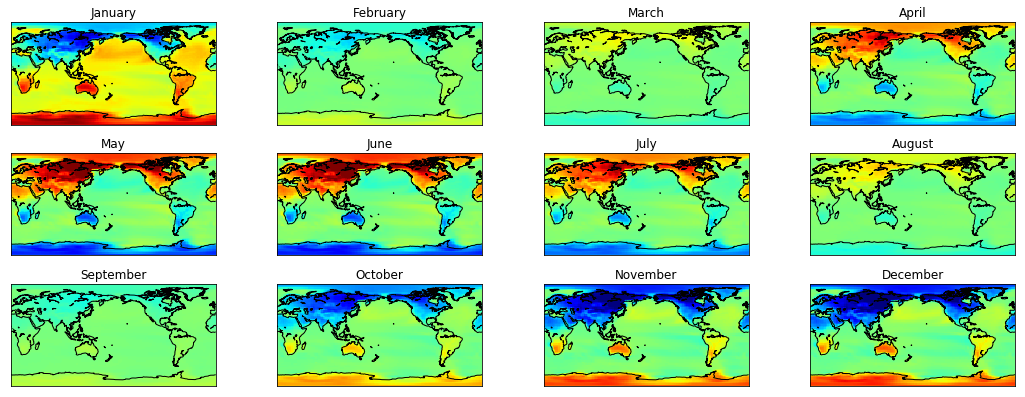

In [62]:
fig = plt.figure(figsize=(18,7))
long = [0, 360]
lat = [-90, 90]

ind = 1
plt.subplot(3, 4, ind)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
    map.drawcoastlines()

    h = map.imshow(Z[1, :], cmap = 'jet', interpolation = 'none', animated = True)
    m = max(abs(Z[1, :].flatten()))
    plt.title('January')
    
ind += 1
month = 0
titles = ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for i in [31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331]:
    plt.subplot(3, 4, ind)
    ind += 1
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
        map.drawcoastlines()

        h2 = map.imshow(Z[i, :], cmap = 'jet', interpolation = 'none', animated = True)
        plt.clim(-m, m)
        plt.title(titles[month])
        month+=1
        
        
plt.subplots_adjust(hspace=0.1, wspace = 0.3)

### Making a movie

In [21]:
test_mov = Z[1::30, :]

In [22]:
test_mov.shape

(317, 72, 144)

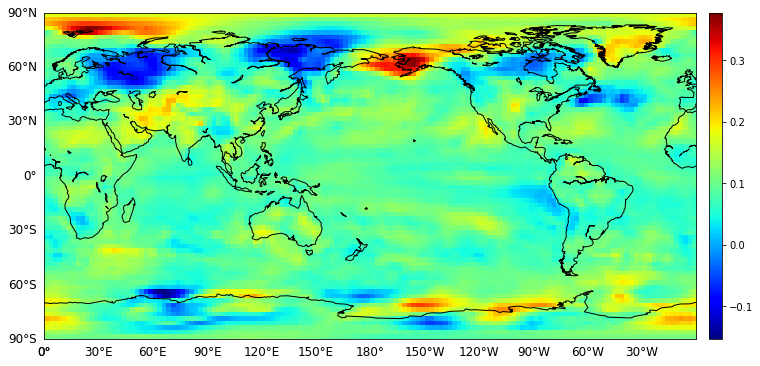

In [27]:
a = helper.make_animation(test_mov, 317)

In [28]:
helper.save_as_vid(a, 'Volcanic_cycle.mp4', fps=30)

In [20]:
helper.load_vid('Volcanic_cycle.mp4')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
